In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

import sys
sys.path.append('../')
import plot_util
import util

2022-03-10 23:58:15.749476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-10 23:58:17.362486: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-10 23:58:17.366160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-10 23:58:17.454722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-10 23:58:17.454791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-10 23:58:17.463121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [2]:
# Note that we are loading the FULL signal and background datasets
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220301_ELReLMIs54_MUReLMIs31_btag77_VVZ.arrow')
sig['is_signal'] = True
bg = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                           + '20220301_ELReLMIs54_MUReLMIs31_btag77_FULLBG.arrow'))
bg['is_signal'] = False

In [3]:
train_feats = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                          'v_j_btag77', 'v_j_btag60', 
                                                          'v_j_btag85', 'v_j_btagCont', 'v_j_btag70']])
print('Using the following training features:')
print(sorted(train_feats))

Using the following training features:
['HT', 'MET', 'METPhi', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_ambiguous', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_ambiguous', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zcand_mass', 'Zlep1_ambiguous', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_ambiguous', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'chisq', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'jet_btagCont_1', 'jet_btagCont_2', 'jet_btagCont_3', 'jet_btagCont_4', 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4', 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4', 'jet_phi_1', 'jet_phi_2', 'jet_phi_3', 'jet_phi_4', 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4', 'lep1_ambiguous', 'lep1_pid', 'lep2_ambiguous', 'lep2_pid', 'lep3_ambiguous', 'lep3_pid', 'lep4_ambiguous', 'lep4_pid', 'leptonic_HT', 'mass_4l', 'other_mass', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'tota

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats], bg[train_feats]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats] = min_max_scaler.transform(df[train_feats])

In [5]:
# Cut to 4l-SF (in Z) signal region
bg = bg[bg.SR == 0]
sig = sig[sig.SR == 0]

# Setup k-folds

In [7]:
combined_data = pd.concat([sig[train_feats + ['wgt', 'is_signal']], bg[train_feats + ['wgt', 'is_signal']]], 
                          ignore_index=True)
combined_labels = np.concatenate([np.ones(len(sig)), np.zeros(len(bg))])

In [8]:
K_FOLDS = 5
k_folder = StratifiedKFold(n_splits = K_FOLDS, random_state=314, shuffle=True)

# Assign k-folds
combined_data['k_fold'] = -1
for i, (_, test_index) in enumerate(k_folder.split(combined_data, combined_labels)):
    combined_data.loc[test_index, 'k_fold'] = i

# Train models

In [ ]:
EPOCHS = 10000
PATIENCE = 200
BATCH_SIZE = 1024
NUM_NODES = 64
DROPOUT = 0.1
LEARN_RATE = 1e-5

def make_model(input_dim, num_nodes, dropout, learn_rate):
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=input_dim, activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return classifier

models = [None] * K_FOLDS

for k in range(K_FOLDS):
    # Generate train and validation samples
    # The test sample has k-index k
    # The validation sample has k-index k - 1
    # The rest is for training
    val_k_index = k - 1
    if val_k_index < 0:
        val_k_index = K_FOLDS - 1
        
    x_val = combined_data[combined_data.k_fold == val_k_index]
    y_val = combined_labels[combined_data.k_fold == val_k_index]
    w_val = np.abs(x_val.wgt)
    
    x_train = combined_data[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    y_train = combined_labels[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    
    n_train_sig = sum(x_train[y_train == 1].wgt)
    n_train_bg = sum(x_train[y_train == 0].wgt)
    
    sig_correction = (n_train_sig + n_train_bg) / (2 * n_train_sig)
    bg_correction = (n_train_sig + n_train_bg) / (2 * n_train_bg)
    w_train = (sig_correction * y_train + bg_correction * (1 - y_train)) * np.abs(x_train.wgt)
    
    # Restrict to training features
    x_train = x_train[train_feats]
    x_val = x_val[train_feats]
    
    # Generate and fit model
    classifier = make_model(input_dim=x_train.shape[1], num_nodes=NUM_NODES, 
                            dropout=DROPOUT, learn_rate=LEARN_RATE)
    
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, 
                                                   restore_best_weights=True)

    history = classifier.fit(x_train, y_train, sample_weight=w_train, 
                             validation_data=(x_val, y_val, w_val),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             verbose=1, callbacks=[es_callback], shuffle=True)
    
    # Save model and history
    model_dir = 'models/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/10000
964/964 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.3545 - val_loss: 0.0012 - val_accuracy: 0.9398
Epoch 2/10000
964/964 [==============================] - 4s 5ms/step - loss: 0.0011 - accuracy: 0.9030 - val_loss: 9.9297e-04 - val_accuracy: 0.8284
Epoch 3/10000
964/964 [==============================] - 4s 4ms/step - loss: 0.0011 - accuracy: 0.8037 - val_loss: 9.3528e-04 - val_accuracy: 0.7231
Epoch 4/10000
964/964 [==============================] - 4s 4ms/step - loss: 0.0010 - accuracy: 0.7180 - val_loss: 9.0216e-04 - val_accuracy: 0.7024
Epoch 5/10000
964/964 [==============================] - 4s 4ms/step - loss: 0.0010 - accuracy: 0.6912 - val_loss: 9.0227e-04 - val_accuracy: 0.6884
Epoch 6/10000
964/964 [==============================] - 4s 4ms/step - loss: 0.0010 - accuracy: 0.6785 - val_loss: 8.8856e-04 - val_accuracy: 0.6872
Epoch 7/10000
964/964 [==============================] - 4s 5ms/step - loss: 0.0010 - accuracy: 0.6764 - val_l

964/964 [==============================] - 4s 5ms/step - loss: 9.1072e-04 - accuracy: 0.6919 - val_loss: 8.1208e-04 - val_accuracy: 0.6881
Epoch 108/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.1352e-04 - accuracy: 0.6906 - val_loss: 8.0053e-04 - val_accuracy: 0.6931
Epoch 109/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.1019e-04 - accuracy: 0.6922 - val_loss: 8.1301e-04 - val_accuracy: 0.6879
Epoch 110/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.2734e-04 - accuracy: 0.6868 - val_loss: 7.9637e-04 - val_accuracy: 0.6934
Epoch 111/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.0910e-04 - accuracy: 0.6903 - val_loss: 8.1770e-04 - val_accuracy: 0.6851
Epoch 112/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.1820e-04 - accuracy: 0.6885 - val_loss: 7.8934e-04 - val_accuracy: 0.6967
Epoch 113/10000
964/964 [==============================] - 4s 5ms/step - loss: 9.0713e

Epoch 160/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.7364e-04 - accuracy: 0.6885 - val_loss: 7.9202e-04 - val_accuracy: 0.6824
Epoch 161/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.7488e-04 - accuracy: 0.6850 - val_loss: 7.8576e-04 - val_accuracy: 0.6837
Epoch 162/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.7892e-04 - accuracy: 0.6840 - val_loss: 7.8861e-04 - val_accuracy: 0.6835
Epoch 163/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.8561e-04 - accuracy: 0.6834 - val_loss: 7.7081e-04 - val_accuracy: 0.6882
Epoch 164/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.8671e-04 - accuracy: 0.6842 - val_loss: 8.0324e-04 - val_accuracy: 0.6770
Epoch 165/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.7294e-04 - accuracy: 0.6840 - val_loss: 7.7839e-04 - val_accuracy: 0.6858
Epoch 166/10000
964/964 [==============================] - 4s 5ms/step

Epoch 213/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.6481e-04 - accuracy: 0.6748 - val_loss: 7.5557e-04 - val_accuracy: 0.6829
Epoch 214/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.6046e-04 - accuracy: 0.6787 - val_loss: 7.6124e-04 - val_accuracy: 0.6801
Epoch 215/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.5246e-04 - accuracy: 0.6795 - val_loss: 7.7776e-04 - val_accuracy: 0.6744
Epoch 216/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.4690e-04 - accuracy: 0.6784 - val_loss: 7.4572e-04 - val_accuracy: 0.6840
Epoch 217/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.5157e-04 - accuracy: 0.6773 - val_loss: 7.3180e-04 - val_accuracy: 0.6890
Epoch 218/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.5417e-04 - accuracy: 0.6778 - val_loss: 7.4321e-04 - val_accuracy: 0.6854
Epoch 219/10000
964/964 [==============================] - 4s 5ms/step

Epoch 266/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.3013e-04 - accuracy: 0.6773 - val_loss: 7.2634e-04 - val_accuracy: 0.6855
Epoch 267/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.2758e-04 - accuracy: 0.6765 - val_loss: 7.1817e-04 - val_accuracy: 0.6877
Epoch 268/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.2128e-04 - accuracy: 0.6785 - val_loss: 7.1461e-04 - val_accuracy: 0.6884
Epoch 269/10000
964/964 [==============================] - 4s 4ms/step - loss: 8.2514e-04 - accuracy: 0.6784 - val_loss: 7.3944e-04 - val_accuracy: 0.6802
Epoch 270/10000
964/964 [==============================] - 4s 4ms/step - loss: 8.2721e-04 - accuracy: 0.6779 - val_loss: 7.5677e-04 - val_accuracy: 0.6733
Epoch 271/10000
964/964 [==============================] - 4s 4ms/step - loss: 8.2634e-04 - accuracy: 0.6741 - val_loss: 7.3210e-04 - val_accuracy: 0.6833
Epoch 272/10000
964/964 [==============================] - 4s 4ms/step

Epoch 319/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.9868e-04 - accuracy: 0.6840 - val_loss: 6.9450e-04 - val_accuracy: 0.6922
Epoch 320/10000
964/964 [==============================] - 4s 5ms/step - loss: 8.0845e-04 - accuracy: 0.6775 - val_loss: 7.0856e-04 - val_accuracy: 0.6882
Epoch 321/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.9673e-04 - accuracy: 0.6806 - val_loss: 7.1351e-04 - val_accuracy: 0.6863
Epoch 322/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.9818e-04 - accuracy: 0.6815 - val_loss: 7.3116e-04 - val_accuracy: 0.6809
Epoch 323/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.9615e-04 - accuracy: 0.6795 - val_loss: 7.0403e-04 - val_accuracy: 0.6890
Epoch 324/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.9754e-04 - accuracy: 0.6830 - val_loss: 7.2179e-04 - val_accuracy: 0.6837
Epoch 325/10000
964/964 [==============================] - 4s 5ms/step

Epoch 372/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.7286e-04 - accuracy: 0.6889 - val_loss: 6.8641e-04 - val_accuracy: 0.6949
Epoch 373/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.8057e-04 - accuracy: 0.6862 - val_loss: 6.6943e-04 - val_accuracy: 0.7005
Epoch 374/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.7983e-04 - accuracy: 0.6872 - val_loss: 6.7848e-04 - val_accuracy: 0.6980
Epoch 375/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.7561e-04 - accuracy: 0.6869 - val_loss: 6.7940e-04 - val_accuracy: 0.6984
Epoch 376/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.7455e-04 - accuracy: 0.6896 - val_loss: 6.8426e-04 - val_accuracy: 0.6952
Epoch 377/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.7531e-04 - accuracy: 0.6882 - val_loss: 6.8776e-04 - val_accuracy: 0.6938
Epoch 378/10000
964/964 [==============================] - 4s 5ms/step

Epoch 425/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.5960e-04 - accuracy: 0.6934 - val_loss: 6.7705e-04 - val_accuracy: 0.6980
Epoch 426/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.5451e-04 - accuracy: 0.6911 - val_loss: 6.7510e-04 - val_accuracy: 0.6979
Epoch 427/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.5235e-04 - accuracy: 0.6906 - val_loss: 6.4798e-04 - val_accuracy: 0.7087
Epoch 428/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.5235e-04 - accuracy: 0.6955 - val_loss: 6.8776e-04 - val_accuracy: 0.6958
Epoch 429/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.5669e-04 - accuracy: 0.6923 - val_loss: 6.4445e-04 - val_accuracy: 0.7088
Epoch 430/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.4494e-04 - accuracy: 0.6967 - val_loss: 6.8987e-04 - val_accuracy: 0.6943
Epoch 431/10000
964/964 [==============================] - 4s 5ms/step

Epoch 478/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.3713e-04 - accuracy: 0.6980 - val_loss: 6.0657e-04 - val_accuracy: 0.7219
Epoch 479/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.3074e-04 - accuracy: 0.7038 - val_loss: 6.4387e-04 - val_accuracy: 0.7100
Epoch 480/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.2791e-04 - accuracy: 0.7008 - val_loss: 6.3829e-04 - val_accuracy: 0.7115
Epoch 481/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.3481e-04 - accuracy: 0.6999 - val_loss: 6.0585e-04 - val_accuracy: 0.7225
Epoch 482/10000
964/964 [==============================] - 3s 4ms/step - loss: 7.3598e-04 - accuracy: 0.7028 - val_loss: 6.1692e-04 - val_accuracy: 0.7179
Epoch 483/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.3228e-04 - accuracy: 0.7021 - val_loss: 6.1326e-04 - val_accuracy: 0.7195
Epoch 484/10000
964/964 [==============================] - 4s 4ms/step

Epoch 531/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.1231e-04 - accuracy: 0.7090 - val_loss: 6.2048e-04 - val_accuracy: 0.7165
Epoch 532/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.1438e-04 - accuracy: 0.7064 - val_loss: 6.2395e-04 - val_accuracy: 0.7153
Epoch 533/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.1141e-04 - accuracy: 0.7073 - val_loss: 6.2195e-04 - val_accuracy: 0.7157
Epoch 534/10000
964/964 [==============================] - 4s 4ms/step - loss: 7.0673e-04 - accuracy: 0.7070 - val_loss: 6.0783e-04 - val_accuracy: 0.7204
Epoch 535/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.1581e-04 - accuracy: 0.7059 - val_loss: 5.9165e-04 - val_accuracy: 0.7264
Epoch 536/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.1568e-04 - accuracy: 0.7069 - val_loss: 6.1065e-04 - val_accuracy: 0.7188
Epoch 537/10000
964/964 [==============================] - 4s 4ms/step

Epoch 584/10000
964/964 [==============================] - 4s 4ms/step - loss: 6.9819e-04 - accuracy: 0.7103 - val_loss: 5.9092e-04 - val_accuracy: 0.7249
Epoch 585/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.0235e-04 - accuracy: 0.7101 - val_loss: 5.9250e-04 - val_accuracy: 0.7256
Epoch 586/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8606e-04 - accuracy: 0.7120 - val_loss: 5.8997e-04 - val_accuracy: 0.7262
Epoch 587/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.9224e-04 - accuracy: 0.7133 - val_loss: 6.0735e-04 - val_accuracy: 0.7188
Epoch 588/10000
964/964 [==============================] - 4s 5ms/step - loss: 7.0139e-04 - accuracy: 0.7082 - val_loss: 5.7500e-04 - val_accuracy: 0.7309
Epoch 589/10000
964/964 [==============================] - 4s 4ms/step - loss: 6.9485e-04 - accuracy: 0.7120 - val_loss: 6.0430e-04 - val_accuracy: 0.7206
Epoch 590/10000
964/964 [==============================] - 4s 4ms/step

Epoch 637/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8378e-04 - accuracy: 0.7155 - val_loss: 5.9491e-04 - val_accuracy: 0.7228
Epoch 638/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8541e-04 - accuracy: 0.7135 - val_loss: 5.8360e-04 - val_accuracy: 0.7274
Epoch 639/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8394e-04 - accuracy: 0.7136 - val_loss: 6.0670e-04 - val_accuracy: 0.7177
Epoch 640/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8142e-04 - accuracy: 0.7142 - val_loss: 5.7921e-04 - val_accuracy: 0.7279
Epoch 641/10000
964/964 [==============================] - 4s 4ms/step - loss: 6.8026e-04 - accuracy: 0.7141 - val_loss: 6.0219e-04 - val_accuracy: 0.7212
Epoch 642/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.8332e-04 - accuracy: 0.7146 - val_loss: 5.8130e-04 - val_accuracy: 0.7287
Epoch 643/10000
964/964 [==============================] - 4s 4ms/step

Epoch 690/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.7373e-04 - accuracy: 0.7154 - val_loss: 5.8271e-04 - val_accuracy: 0.7262
Epoch 691/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.7637e-04 - accuracy: 0.7145 - val_loss: 6.2054e-04 - val_accuracy: 0.7137
Epoch 692/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.7739e-04 - accuracy: 0.7130 - val_loss: 5.8621e-04 - val_accuracy: 0.7246
Epoch 693/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.7024e-04 - accuracy: 0.7156 - val_loss: 5.8746e-04 - val_accuracy: 0.7246
Epoch 694/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6689e-04 - accuracy: 0.7170 - val_loss: 5.9692e-04 - val_accuracy: 0.7214
Epoch 695/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.7320e-04 - accuracy: 0.7150 - val_loss: 5.6441e-04 - val_accuracy: 0.7337
Epoch 696/10000
964/964 [==============================] - 4s 5ms/step

Epoch 743/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6473e-04 - accuracy: 0.7160 - val_loss: 5.7196e-04 - val_accuracy: 0.7281
Epoch 744/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6098e-04 - accuracy: 0.7170 - val_loss: 5.7381e-04 - val_accuracy: 0.7274
Epoch 745/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5808e-04 - accuracy: 0.7176 - val_loss: 5.8308e-04 - val_accuracy: 0.7239
Epoch 746/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6997e-04 - accuracy: 0.7129 - val_loss: 5.7482e-04 - val_accuracy: 0.7267
Epoch 747/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6311e-04 - accuracy: 0.7156 - val_loss: 5.5059e-04 - val_accuracy: 0.7354
Epoch 748/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5885e-04 - accuracy: 0.7178 - val_loss: 5.9580e-04 - val_accuracy: 0.7192
Epoch 749/10000
964/964 [==============================] - 4s 5ms/step

Epoch 796/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6347e-04 - accuracy: 0.7140 - val_loss: 5.7254e-04 - val_accuracy: 0.7261
Epoch 797/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5587e-04 - accuracy: 0.7167 - val_loss: 5.7192e-04 - val_accuracy: 0.7264
Epoch 798/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5497e-04 - accuracy: 0.7165 - val_loss: 5.5522e-04 - val_accuracy: 0.7326
Epoch 799/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5443e-04 - accuracy: 0.7192 - val_loss: 5.8528e-04 - val_accuracy: 0.7227
Epoch 800/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.6157e-04 - accuracy: 0.7155 - val_loss: 5.6891e-04 - val_accuracy: 0.7272
Epoch 801/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5514e-04 - accuracy: 0.7175 - val_loss: 5.7457e-04 - val_accuracy: 0.7255
Epoch 802/10000
964/964 [==============================] - 4s 5ms/step

Epoch 849/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4742e-04 - accuracy: 0.7178 - val_loss: 5.8432e-04 - val_accuracy: 0.7205
Epoch 850/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4860e-04 - accuracy: 0.7157 - val_loss: 5.9362e-04 - val_accuracy: 0.7189
Epoch 851/10000
964/964 [==============================] - 4s 4ms/step - loss: 6.5344e-04 - accuracy: 0.7161 - val_loss: 5.6392e-04 - val_accuracy: 0.7286
Epoch 852/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5643e-04 - accuracy: 0.7179 - val_loss: 5.6153e-04 - val_accuracy: 0.7290
Epoch 853/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.5214e-04 - accuracy: 0.7191 - val_loss: 5.7703e-04 - val_accuracy: 0.7237
Epoch 854/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4849e-04 - accuracy: 0.7176 - val_loss: 5.5691e-04 - val_accuracy: 0.7313
Epoch 855/10000
964/964 [==============================] - 4s 5ms/step

Epoch 902/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3936e-04 - accuracy: 0.7220 - val_loss: 5.8061e-04 - val_accuracy: 0.7232
Epoch 903/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4181e-04 - accuracy: 0.7186 - val_loss: 5.5605e-04 - val_accuracy: 0.7323
Epoch 904/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4251e-04 - accuracy: 0.7204 - val_loss: 5.6900e-04 - val_accuracy: 0.7257
Epoch 905/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3829e-04 - accuracy: 0.7193 - val_loss: 5.8745e-04 - val_accuracy: 0.7202
Epoch 906/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4819e-04 - accuracy: 0.7162 - val_loss: 5.8435e-04 - val_accuracy: 0.7209
Epoch 907/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4903e-04 - accuracy: 0.7159 - val_loss: 5.5962e-04 - val_accuracy: 0.7291
Epoch 908/10000
964/964 [==============================] - 4s 5ms/step

Epoch 956/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4137e-04 - accuracy: 0.7206 - val_loss: 5.7578e-04 - val_accuracy: 0.7233
Epoch 957/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4518e-04 - accuracy: 0.7169 - val_loss: 5.6937e-04 - val_accuracy: 0.7256
Epoch 958/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4487e-04 - accuracy: 0.7166 - val_loss: 5.8573e-04 - val_accuracy: 0.7203
Epoch 959/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4309e-04 - accuracy: 0.7165 - val_loss: 5.6314e-04 - val_accuracy: 0.7279
Epoch 960/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4563e-04 - accuracy: 0.7176 - val_loss: 5.7356e-04 - val_accuracy: 0.7240
Epoch 961/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3763e-04 - accuracy: 0.7193 - val_loss: 5.7579e-04 - val_accuracy: 0.7231
Epoch 962/10000
964/964 [==============================] - 4s 5ms/step

Epoch 1009/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3771e-04 - accuracy: 0.7160 - val_loss: 5.6034e-04 - val_accuracy: 0.7274
Epoch 1010/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3319e-04 - accuracy: 0.7168 - val_loss: 5.7094e-04 - val_accuracy: 0.7234
Epoch 1011/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4024e-04 - accuracy: 0.7164 - val_loss: 5.7523e-04 - val_accuracy: 0.7240
Epoch 1012/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4318e-04 - accuracy: 0.7181 - val_loss: 5.5608e-04 - val_accuracy: 0.7289
Epoch 1013/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.4431e-04 - accuracy: 0.7158 - val_loss: 5.6601e-04 - val_accuracy: 0.7261
Epoch 1014/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3789e-04 - accuracy: 0.7181 - val_loss: 5.7276e-04 - val_accuracy: 0.7231
Epoch 1015/10000
964/964 [==============================] - 4s 5

964/964 [==============================] - 4s 5ms/step - loss: 6.3205e-04 - accuracy: 0.7188 - val_loss: 5.8335e-04 - val_accuracy: 0.7178
Epoch 1114/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2486e-04 - accuracy: 0.7175 - val_loss: 5.5212e-04 - val_accuracy: 0.7285
Epoch 1115/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3246e-04 - accuracy: 0.7181 - val_loss: 5.7959e-04 - val_accuracy: 0.7187
Epoch 1116/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3156e-04 - accuracy: 0.7169 - val_loss: 5.6108e-04 - val_accuracy: 0.7264
Epoch 1117/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2490e-04 - accuracy: 0.7191 - val_loss: 5.6587e-04 - val_accuracy: 0.7240
Epoch 1118/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3609e-04 - accuracy: 0.7177 - val_loss: 5.6086e-04 - val_accuracy: 0.7253
Epoch 1119/10000
964/964 [==============================] - 4s 5ms/step - loss: 6

964/964 [==============================] - 4s 5ms/step - loss: 6.2482e-04 - accuracy: 0.7167 - val_loss: 5.6264e-04 - val_accuracy: 0.7256
Epoch 1218/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2625e-04 - accuracy: 0.7189 - val_loss: 5.5964e-04 - val_accuracy: 0.7268
Epoch 1219/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2542e-04 - accuracy: 0.7190 - val_loss: 5.8001e-04 - val_accuracy: 0.7188
Epoch 1220/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2234e-04 - accuracy: 0.7166 - val_loss: 5.5619e-04 - val_accuracy: 0.7267
Epoch 1221/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.2148e-04 - accuracy: 0.7193 - val_loss: 5.6938e-04 - val_accuracy: 0.7230
Epoch 1222/10000
964/964 [==============================] - 4s 5ms/step - loss: 6.3053e-04 - accuracy: 0.7156 - val_loss: 5.6381e-04 - val_accuracy: 0.7235
Epoch 1223/10000
964/964 [==============================] - 4s 5ms/step - loss: 6

# Analyze results

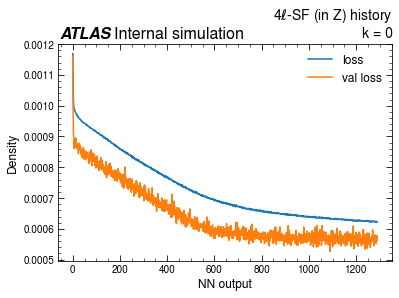

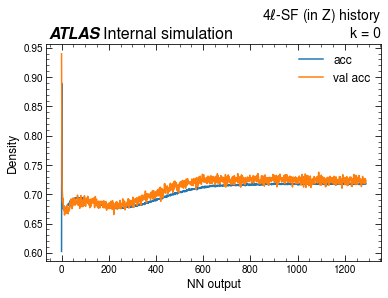

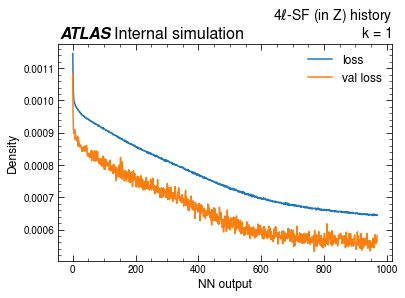

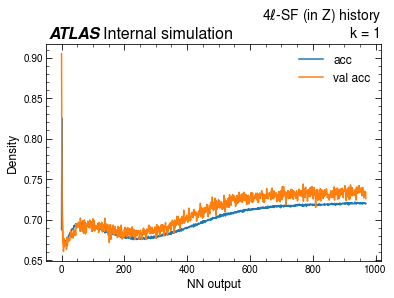

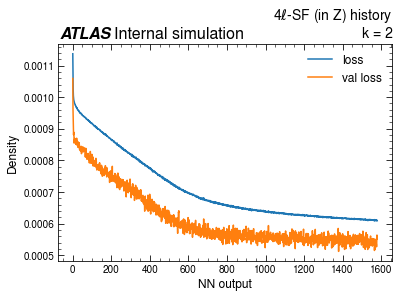

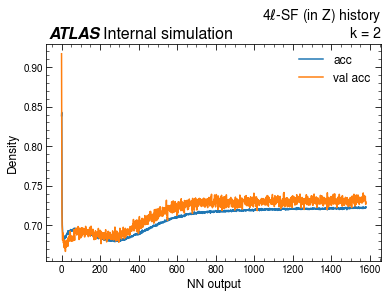

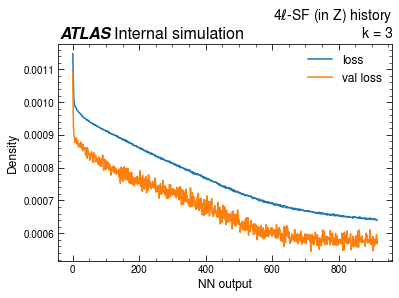

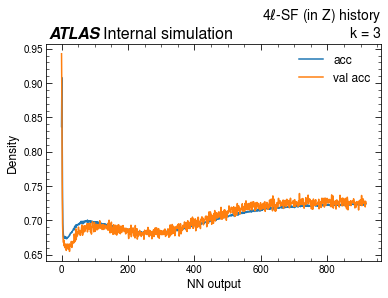

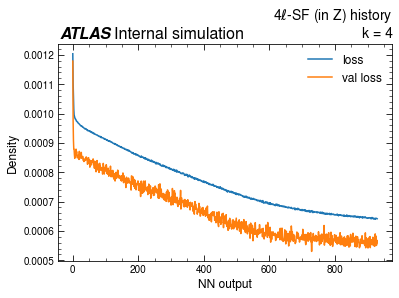

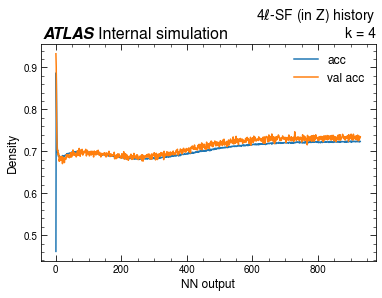

In [18]:
# Generate training history plots
for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_inZ/'
    plot_dir = 'plots/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    with open(model_dir + model_name + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (in Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_loss')
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (in Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_acc')
    plt.show()

In [19]:
nn_out_col = 'nn_out'

combined_data[nn_out_col] = -1

for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_inZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    K.clear_session()
    classifier = keras.models.load_model(model_dir + model_name)
    
    # We test classifier k on slice k
    x_test = combined_data[combined_data.k_fold == k][train_feats]
    combined_data.loc[combined_data.k_fold == k, nn_out_col] = classifier.predict(x_test, batch_size=10000)

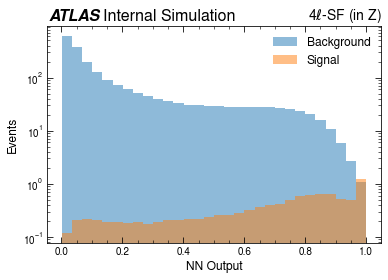

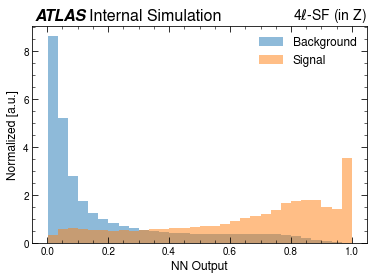

In [20]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]


plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', 
                              save=True, save_dir='plots/SR_SF_inZ/', save_name='nn_output', 
                              title='4$\ell$-SF (in Z)', log=True)
plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', density=True, 
                              save=True, save_dir='plots/SR_SF_inZ/', save_name='nn_output_density', 
                              title='4$\ell$-SF (in Z)', log=False)

In [21]:
n_cuts = 100

cuts = np.arange(0, 1, 1./n_cuts)
sigs = [-1]*n_cuts

max_sig = -1
max_sig_loc = -1

for i, nn_cut in enumerate(cuts):
    bg_sample = combined_data[(combined_data.is_signal == 0)&(combined_data.nn_out >= nn_cut)]
    sig_sample = combined_data[(combined_data.is_signal == 1)&(combined_data.nn_out >= nn_cut)]

    n_sig = sum(sig_sample.wgt)
    n_bg = sum(bg_sample.wgt)

    sig = util.significance(n_sig, n_bg)
    sigs[i] = sig
    if sig > max_sig:
        max_sig = sig
        max_sig_loc = nn_cut

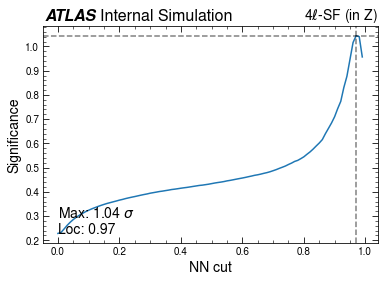

In [22]:
# Plot scan
plt.figure(figsize=(6, 4))
plt.plot(cuts, sigs)

plt.axhline(y=max_sig, color='black', ls='--', alpha=0.5)
plt.axvline(x=max_sig_loc, color='black', ls='--', alpha=0.5)

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-SF (in Z)', loc='right', fontsize=14)

plt.text(min(cuts), min(sigs), 
         'Max: %.2f $\sigma$\nLoc: %.2f'%(max_sig, max_sig_loc),
         fontsize=14)

atlasify('Internal Simulation', outside=True)

plot_util.save_fig('plots/SR_SF_inZ/', 'sig_scan')